#packages to install

including the librarys, and connection to the google drives

In [ ]:
!pip install skorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split 
from skorch import NeuralNetClassifier

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from   torch.utils.data import Subset  #random_split, SubsetRandomSampler, DataLoader
from   torchvision.datasets import ImageFolder, DatasetFolder

from collections import Counter
import concurrent.futures as cf
import cv2
import dlib
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import sys
import time
from tqdm import tqdm

# !nvcc --version
print("torch version:",torch.__version__)
print("torchvision version:",torchvision.__version__)
print('PIL',PIL.__version__)


torch version: 1.10.0+cu111
torchvision version: 0.11.1+cu111
PIL 7.1.2


#load data and the directory names
load data from the directory and list its corresponding class names

In [ ]:
def load_dataset(directory_path):
  image_transforms = transforms.Compose(
                    [
                     transforms.ToTensor(),
                    #  transforms.Normalize(mean=(0.54029465, 0.4816059, 0.45236158), std=(0.2540607, 0.24196939, 0.23964395)),
                     # new mean and std at 2022-april-9:
                     transforms.Normalize(mean=(0.53381044, 0.4986136, 0.47636956), 
                                          std=(0.2540607, 0.24196917, 0.23964413)),
                     transforms.Resize((88,88))
                    ])
  
  dataset = ImageFolder(
                        root = directory_path,
                        transform = image_transforms
                        )
  return dataset


directory_path = '/content/drive/My Drive/6721Project3/train'   #6721Project2
dataset = load_dataset(directory_path)

## function to getMeanAndStd
only used to process pictures, not used in the actual code session

In [ ]:
"""
def getMeanAndStd(train_data):
    '''
    Compute mean and variance for training data
    :param train_data: Dataset
    :return: (mean, std)
    '''
    print('Compute mean and variance for training data.')
    print(len(train_data))
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=1, shuffle=False, num_workers=0,
        pin_memory=True)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    # print(type(train_loader), train_loader)
    # for i, (images, labels) in enumerate(train_loader):
    #     print(images, labels)
    for X, _ in train_loader:
        for d in range(3):
            mean[d] += X[:, d, :, :].mean()
            std[d] += X[:, d, :, :].std()
    mean.div_(len(train_data))
    std.div_(len(train_data))
    return list(mean.numpy()), list(std.numpy())

train_dataset = ImageFolder(directory_path, transform=None)
getMeanAndStd(dataset)
"""
#[0.54029465, 0.4816059, 0.45236158], [0.2540607, 0.24196939, 0.23964395]
#[0.0050816885, -0.03008429, -0.042872783], [1.0050461, 1.0116265, 1.0180334]


"\ndef getMeanAndStd(train_data):\n    '''\n    Compute mean and variance for training data\n    :param train_data: Dataset\n    :return: (mean, std)\n    '''\n    print('Compute mean and variance for training data.')\n    print(len(train_data))\n    train_loader = torch.utils.data.DataLoader(\n        train_data, batch_size=1, shuffle=False, num_workers=0,\n        pin_memory=True)\n    mean = torch.zeros(3)\n    std = torch.zeros(3)\n    # print(type(train_loader), train_loader)\n    # for i, (images, labels) in enumerate(train_loader):\n    #     print(images, labels)\n    for X, _ in train_loader:\n        for d in range(3):\n            mean[d] += X[:, d, :, :].mean()\n            std[d] += X[:, d, :, :].std()\n    mean.div_(len(train_data))\n    std.div_(len(train_data))\n    return list(mean.numpy()), list(std.numpy())\n\ntrain_dataset = ImageFolder(directory_path, transform=None)\ngetMeanAndStd(dataset)\n"

## function to plot the confusion matrix
a function to plot the summary of k fold cross validation data into a confusion matrix

In [ ]:
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


###double check if the classe names are right

In [ ]:
classes = dataset.classes
NUM_CLASSES = len(classes)
print("classes=", classes)
print("NUM_CLASSES=", NUM_CLASSES)
to_pil_image = transforms.ToPILImage()

print(dataset.class_to_idx)
print(dataset.imgs)
print(dataset.imgs[0][1])

classes= ['Cloth mask', 'N95 mask', 'Surgical mask', 'no mask', 'with valve']
NUM_CLASSES= 5
{'Cloth mask': 0, 'N95 mask': 1, 'Surgical mask': 2, 'no mask': 3, 'with valve': 4}
[('/content/drive/My Drive/6721Project3/train/Cloth mask/0311.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/0367.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/0655.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/0731.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/0771.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/08391.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/0862.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/0864.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/0866.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/0867.png', 0), ('/content/drive/My Drive/6721Project3/train/Cloth mask/08671.png', 0), ('/content/drive/My Drive/6721Project3/

### spliting data
but only for the first deliverable code, not used in the second deliverable

In [ ]:
'''
train_size = int(0.75 * len(dataset))
test_size = (len(dataset) - train_size)
#train_dataset, val_dataset, test_dataset = data.random_split(dataset, [train_size, test_size, test_size])
#TypeError: randperm() received an invalid combination of arguments - got (float, generator=torch._C.Generator), but expected one of:

lengths = [train_size, test_size]
train_dataset, test_dataset = data.random_split(dataset, lengths)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)
'''


'\ntrain_size = int(0.75 * len(dataset))\ntest_size = (len(dataset) - train_size)\n#train_dataset, val_dataset, test_dataset = data.random_split(dataset, [train_size, test_size, test_size])\n#TypeError: randperm() received an invalid combination of arguments - got (float, generator=torch._C.Generator), but expected one of:\n\nlengths = [train_size, test_size]\ntrain_dataset, test_dataset = data.random_split(dataset, lengths)\n\ntrain_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)\ntest_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)\n'

## declare the path and test sets
get prepared for loading data later

In [ ]:

path_train = '/content/drive/My Drive/6721Project3/train'  #'/content/drive/My Drive/6721Project2/train'  

train_dataset = load_dataset(path_train)

path_female = '/content/drive/My Drive/6721Project3/test/female' #'/content/drive/My Drive/6721Project2/test/female'  
path_male = '/content/drive/My Drive/6721Project3/test/male' #'/content/drive/My Drive/6721Project2/test/male' 
path_child = '/content/drive/My Drive/6721Project3/test/child' #'/content/drive/My Drive/6721Project2/test/child'
path_adult = '/content/drive/My Drive/6721Project3/test/adult'  #'/content/drive/My Drive/6721Project2/test/adult'
path_elder = '/content/drive/My Drive/6721Project3/test/elder' #'/content/drive/My Drive/6721Project2/test/elder'

test_female = load_dataset(path_female)
test_male = load_dataset(path_male)
test_child = load_dataset(path_child)
test_adult = load_dataset(path_adult)
test_elder = load_dataset(path_elder)


In [ ]:

# train dataset
train_idxs = np.arange(len(train_dataset))
train_labels = np.array(train_dataset.targets)[train_idxs]
# test female
test_female_idxs = np.arange(len(test_female))
test_female_labels = np.array(test_female.targets)[test_female_idxs]
# test male
test_male_idxs = np.arange(len(test_male))
test_male_labels = np.array(test_male.targets)[test_male_idxs]
# test child
test_child_idxs = np.arange(len(test_child))
test_child_labels = np.array(test_child.targets)[test_child_idxs]
# test adult
test_adult_idxs = np.arange(len(test_adult))
test_adult_labels = np.array(test_adult.targets)[test_adult_idxs]
# test elder
test_elder_idxs = np.arange(len(test_elder))
test_elder_labels = np.array(test_elder.targets)[test_elder_idxs]

print(train_dataset.class_to_idx)
print(test_female.class_to_idx)

{'Cloth mask': 0, 'N95 mask': 1, 'Surgical mask': 2, 'no mask': 3, 'with valve': 4}
{'Cloth mask': 0, 'N95 mask': 1, 'Surgical mask': 2, 'no mask': 3, 'with valve': 4}


##print out data info
so that we can visualize all the data we have 

<BarContainer object of 5 artists>

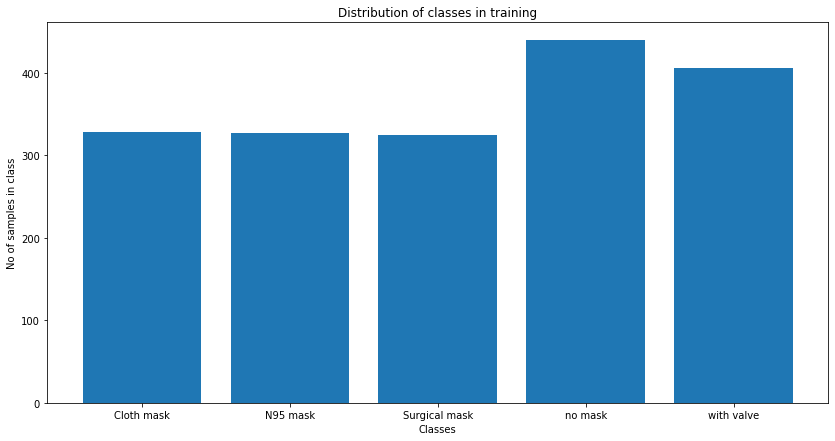

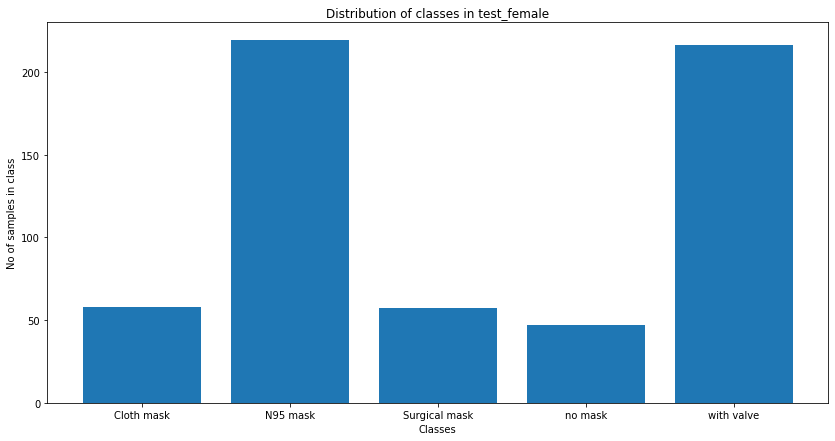

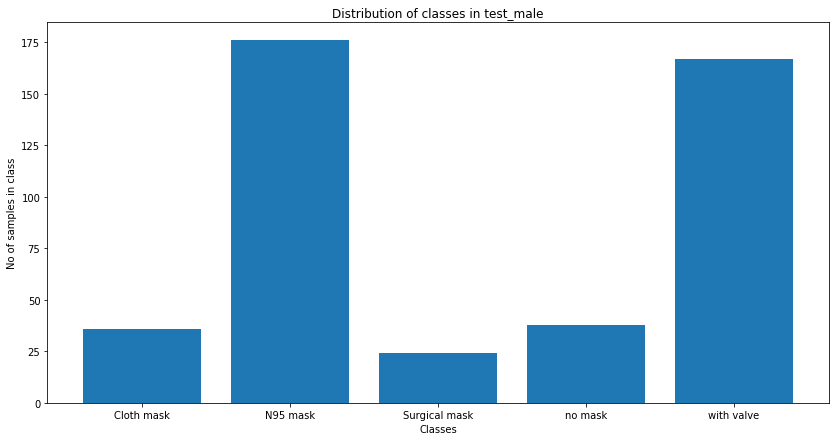

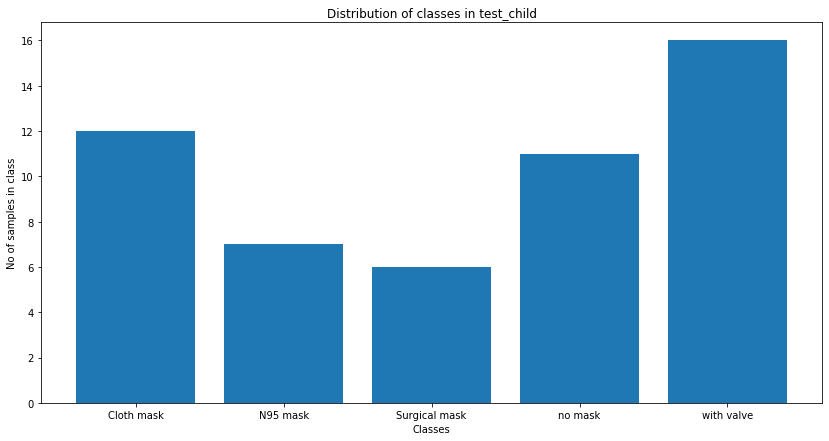

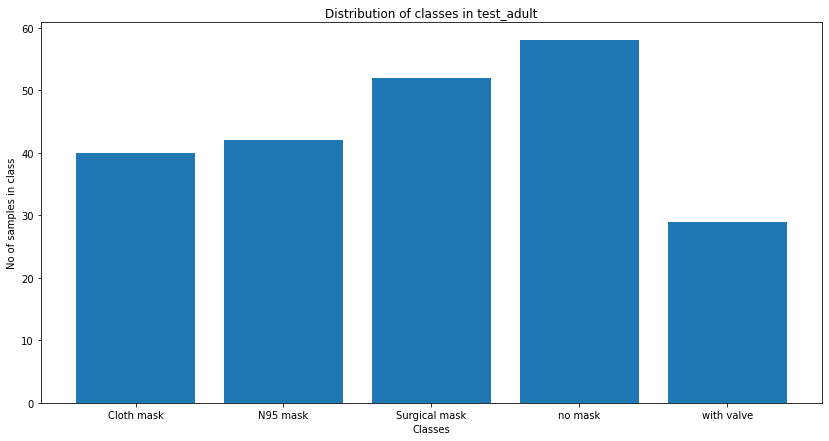

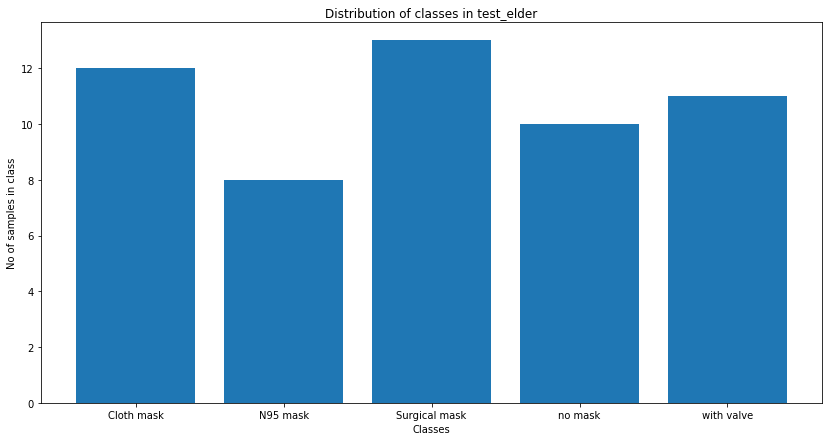

In [ ]:

plt.figure(figsize=(14,7))
plt.plot(1)
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(11),train_dataset.class_to_idx.keys())
train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())

plt.figure(figsize=(14,7))
plt.plot(2)
plt.title('Distribution of classes in test_female')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(11),test_female.class_to_idx.keys())
female_labels_dist = Counter(test_female_labels)
plt.bar(female_labels_dist.keys(), female_labels_dist.values())

plt.figure(figsize=(14,7))
plt.plot(3)
plt.title('Distribution of classes in test_male')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(11),test_male.class_to_idx.keys())
male_labels_dist = Counter(test_male_labels)
plt.bar(male_labels_dist.keys(), male_labels_dist.values())

plt.figure(figsize=(14,7))
plt.plot(4)
plt.title('Distribution of classes in test_child')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(11),test_child.class_to_idx.keys())
child_labels_dist = Counter(test_child_labels)
plt.bar(child_labels_dist.keys(), child_labels_dist.values())

plt.figure(figsize=(14,7))
plt.plot(5)
plt.title('Distribution of classes in test_adult')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(11),test_adult.class_to_idx.keys())
adult_labels_dist = Counter(test_adult_labels)
plt.bar(adult_labels_dist.keys(), adult_labels_dist.values())

plt.figure(figsize=(14,7))
plt.plot(6)
plt.title('Distribution of classes in test_elder')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(11),test_elder.class_to_idx.keys())
elder_labels_dist = Counter(test_elder_labels)
plt.bar(elder_labels_dist.keys(), elder_labels_dist.values())


#model for CNN
defined model to run cnn later

In [ ]:
class CNN(nn.Module):  #the definition of CNN, need to change the input channels and the final output
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),    
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32,out_channels=64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),    
            nn.LeakyReLU(inplace=True),            
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),    
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),    
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512),    
            nn.LeakyReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(512*5*5, 1000),      
            nn.ReLU(inplace=True),
            
            nn.Linear(1000, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)  # flatten
        x = x.view(x.size(0), -1)
        print('x', type(x))
        # fc layer
        x = self.fc_layer(x)
        return x

##function to train model

In [ ]:
def model_training(train_loader):
    num_epochs = 4  # 10
    learning_rate = 0.0001  #0.00001    #set up data here, can change later

    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_step = len(train_loader)
    loss_list = []
    acc_list = []

    best_accuracy = 0

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader): 
      # Forward pass      #can' avoid this warnning, can only try to skip it
        #print(images.size())  #'torch.Tensor'   #torch.Size([32, 3, 100, 100]), 32 images of 100*100, everything else r the same
            outputs = model(images)        #mat1 and mat2 shapes cannot be multiplied (32x40000 and 4096x1000)
            loss = criterion(outputs, labels)   #AssertionError: can only test a child process
            loss_list.append(loss.item())

            ## Backprop and optimisation
            optimizer.zero_grad()
            #print(loss,' i is',i,' epoch is ',epoch)
            loss.backward()
            optimizer.step()

            ## Train accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))
  
    return model    

##function to test the accuracy of the model

In [ ]:
def testing_model(test_loader,model):
  with torch.no_grad():
    correct = 0
  total = 0
  index = 0
  for i, (images, labels) in enumerate(test_loader):  # need to separate testset into another set first, then do this
    index += 1
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print('index=',index, 'Test Accuracy of the model on the 2000 test images: {:.2%} %'.format((correct / total) ))
    
    precision = metrics.precision_score(labels, predicted, average="macro")
    recall = recall_score(labels, predicted, average='macro')
    F1 = 2 * precision * recall/(precision + recall)
    conf_matrix = confusion_matrix(labels, predicted)

    print("precision=", '{:.2%} %'.format(precision), 
          " &recall=",  '{:.2%} %'.format(recall), 
          " &F1=",      '{:.2%} %'.format(F1) )
    print("Classification Report:\n", classification_report(labels, predicted, zero_division=1))
    print("")
    return precision, conf_matrix

###testing train and test function
not really used in the actual code

In [ ]:
# remark it temporary
"""
def run_model(run):  
  tic = time.time()
  model = run
  model = model_training(train_loader)

  model.eval()
  precision,conf_matrix = testing_model(test_loader, model)

  #save model
  #best_accuracy = 0
  # if (correct / total)>best_accuracy:
  #   model_save_name = 'classifier.pt'
  #   path = F"/content/drive/My Drive/COMP6721Project/{model_save_name}"
  #   torch.save(model.state_dict(), path)
  #   best_accuracy = correct / total

  toc = time.time()
  print('duration  of testing_model=', toc - tic)

run_model(CNN())
"""

'\ndef run_model(run):  \n  tic = time.time()\n  model = run\n  model = model_training(train_loader)\n\n  model.eval()\n  precision,conf_matrix = testing_model(test_loader, model)\n\n  #save model\n  #best_accuracy = 0\n  # if (correct / total)>best_accuracy:\n  #   model_save_name = \'classifier.pt\'\n  #   path = F"/content/drive/My Drive/COMP6721Project/{model_save_name}"\n  #   torch.save(model.state_dict(), path)\n  #   best_accuracy = correct / total\n\n  toc = time.time()\n  print(\'duration  of testing_model=\', toc - tic)\n\nrun_model(CNN())\n'

#K-Fold cross validation
k fold function code mixed with the code to save the model

In [ ]:
start_time = time.time()

def k_fold_valid(k,train_idxs,train_labels,train_dataset, test_dataset):  #https://www.askpython.com/python/examples/k-fold-cross-validation  #reference here
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    model = CNN()
    avg_accuracy = 0
    total_conf_matrix = np.zeros((5, 5))
    best_accu = 0
    best_model = None
    for index, (train_index, test_index) in enumerate(kf.split(train_idxs,train_labels)):
        #train_fold = Subset(dataset, train_idxs[train_index])
        #test_fold = Subset(dataset, train_idxs[test_index])
        
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

        model = model_training(train_loader)
        model.eval()
        cur_accu, conf_matrix  = testing_model(test_loader, model)   #inside of testing_model, the scores will be printed out
        
        #if cur_accu > best_accu:
        #    best_accu = cur_accu
        #    best_model = model
        avg_accuracy = avg_accuracy + cur_accu
        #total_conf_matrix = np.add(total_conf_matrix, conf_matrix)
        
    print("after k fold the accuracy is %3f" % (avg_accuracy/k), 'the fold is ',index+1)      
    return conf_matrix
    #return total_conf_matrix

       
    # model_save_name = 'classifier.pt'
    # path = F"/content/drive/My Drive/6721Project/{model_save_name}"
    # torch.save(model.state_dict(), path)




##running k fold

x <class 'torch.Tensor'>
Epoch [1/4], Step [1/56], Loss: 2.2542, Accuracy: 18.75%
x <class 'torch.Tensor'>
Epoch [1/4], Step [2/56], Loss: 1.9757, Accuracy: 12.50%
x <class 'torch.Tensor'>
Epoch [1/4], Step [3/56], Loss: 1.9116, Accuracy: 34.38%
x <class 'torch.Tensor'>
Epoch [1/4], Step [4/56], Loss: 1.5202, Accuracy: 40.62%
x <class 'torch.Tensor'>
Epoch [1/4], Step [5/56], Loss: 1.4804, Accuracy: 43.75%
x <class 'torch.Tensor'>
Epoch [1/4], Step [6/56], Loss: 1.4316, Accuracy: 37.50%
x <class 'torch.Tensor'>
Epoch [1/4], Step [7/56], Loss: 1.3455, Accuracy: 43.75%
x <class 'torch.Tensor'>
Epoch [1/4], Step [8/56], Loss: 1.6459, Accuracy: 28.12%
x <class 'torch.Tensor'>
Epoch [1/4], Step [9/56], Loss: 1.3353, Accuracy: 46.88%
x <class 'torch.Tensor'>
Epoch [1/4], Step [10/56], Loss: 1.6532, Accuracy: 37.50%
x <class 'torch.Tensor'>
Epoch [1/4], Step [11/56], Loss: 1.1939, Accuracy: 43.75%
x <class 'torch.Tensor'>
Epoch [1/4], Step [12/56], Loss: 1.0017, Accuracy: 62.50%
x <class 'tor

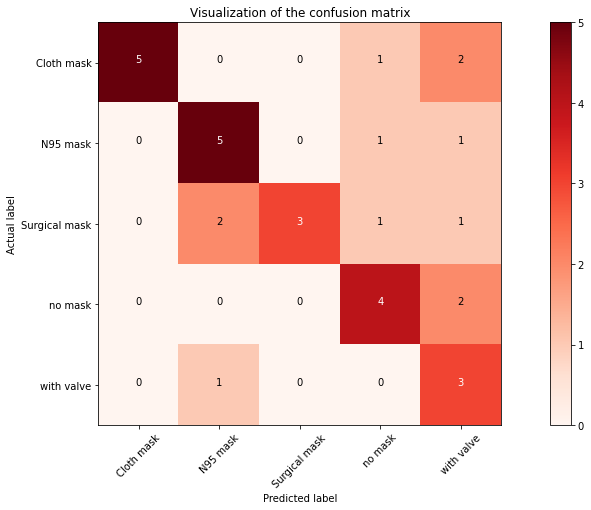

In [ ]:
k = 3  #10 #2 

total_conf_matrix = k_fold_valid(k,train_idxs,train_labels,train_dataset,test_elder)  
 

plot_cm(total_conf_matrix, classes)

end_time = time.time()
print('duration of k_fold_valid=', end_time - start_time)

##code to load model
only used for demo


In [ ]:
# model = CNN()
# model_path = "/content/drive/My Drive/6721Project/classifier.pt"   
# # model = torch.load(model_path)
# model.load_state_dict(torch.load(model_path))
# model.eval()